In [9]:
import numpy as np 
import torch 
import garch_framework as frame
from garch_framework.layers.losses import CorrectedNLoss
from garch_framework.utils.helpers import generate_ground_data, save_model_params
from garch_framework.utils.datasets import GJRGARCHDataset
from garch_framework.models import GARCHModel, GJRGARCHModel
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from arch import arch_model
import torch
import torch.nn as nn

In [2]:
omega=0.2
alpha=0.2
gamma= 0.05
beta=0.5

In [3]:
grounds = [omega, alpha, gamma, beta]

In [4]:
data, volat = generate_ground_data(mode = 'GJRGARCH',omega=omega, alpha=alpha, gamma=gamma,beta=beta, n=10000)

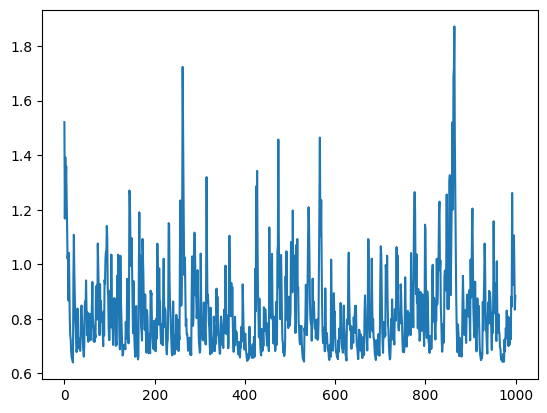

In [5]:
plt.plot(volat[:1000])

In [8]:
class LstmGarchDataset(Dataset):
    def __init__(self, residuals, volatility, h=1):
        super().__init__()
        self.epsilons = torch.tensor(residuals, dtype=torch.float32)
        self.sigmas = torch.tensor(volatility, dtype=torch.float32) 
        self.h = h
    
    def __len__(self):
        return len(self.epsilons)  - self.h +1 
    
    def __getitem__(self, index):

        return (self.epsilons[index],
        self.sigmas[index],
        self.epsilons[index + self.h])


In [ ]:
class GARCHLSTM(nn.Module):
    def __init__(self, garch_core, hidden_size=16, mode = 'gjrgarch', scale = 1):
        super().__init__()
        self.garch_core = garch_core  # объект класса GARCHModel / GJRGARCHModel / FIGARCHModel

        # LSTM "ядро памяти" на вход [ε_{t-1}, σ²_{t-1}]
        self.W_f = nn.Linear(2, hidden_size)
        self.U_f = nn.Linear(1, hidden_size, bias=False)

        self.W_i = nn.Linear(2, hidden_size)
        self.U_i = nn.Linear(1, hidden_size, bias=False)

        self.W_c = nn.Linear(2, hidden_size)
        self.U_c = nn.Linear(1, hidden_size, bias=False)

        self.o_gate_linear = nn.Linear(2, 1)  # для создания w ∈ [0, 1]
        self.w = nn.Parameter(torch.tensor(0.5))  # learnable controller

        self.hidden_size = hidden_size
        self.scale = scale
        self.mode = mode
    
    def init_hidden(self, batch_size):
        """Инициализация начального состояния памяти"""
        return torch.zeros(batch_size, self.hidden_size)



    def forward(self, eps_t_minus_1, sigma2_t_minus_1, c_t_minus_1, eps_window=None):
        """
        eps_t_minus_1: [batch_size, 1]
        sigma2_t_minus_1: [batch_size, 1]
        c_t_minus_1: [batch_size, hidden_size]
        eps_window: [batch_size, truncation_size] — только для FIGARCH
        """

        if eps_t_minus_1 is None or sigma2_t_minus_1 is None:
            raise ValueError("eps_t_minus_1 и sigma2_t_minus_1 не могут быть None")


        if c_t_minus_1 is None:
            batch_size = eps_t_minus_1.size(0)
            c_t_minus_1 = self.init_hidden(batch_size).to(eps_t_minus_1.device)

        x = torch.cat([eps_t_minus_1, sigma2_t_minus_1], dim=1)  # [batch_size, 2]

        f_t = torch.sigmoid(self.W_f(x) + self.U_f(sigma2_t_minus_1))
        i_t = torch.sigmoid(self.W_i(x) + self.U_i(sigma2_t_minus_1))
        c1_t = torch.tanh(self.W_c(x) + self.U_c(sigma2_t_minus_1))

        c_t = f_t * c_t_minus_1 + i_t * c1_t

        # Вставка GARCH ядра
        if self.mode == 'figarch':
            garch_input = eps_window 

        elif self.mode == 'gjrgarch':
            eps2 = eps_t_minus_1 ** 2
            indicator = (eps_t_minus_1 < 0).float()
            asymm = eps2 * indicator
            omega_const = torch.ones_like(eps2) * self.scale
            garch_input = torch.cat([omega_const, eps2, asymm, sigma2_t_minus_1], dim=1)  # [batch_size, 4]

        elif self.mode == 'garch':
            garch_input = torch.cat([eps_t_minus_1, sigma2_t_minus_1], dim=1)  # [batch_size, 2]

        else:
            raise ValueError(f"Неизвестный режим ядра: {self.mode}")

        o_t = self.garch_core(garch_input).unsqueeze(1)

        sigma2_t = o_t * (1 + self.w * torch.tanh(c_t).mean(dim=1, keepdim=True))

        return sigma2_t, c_t
